# Система ОДУ



In [2]:
# libraries include
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
# Problem
def x_f(x, y):
    return y
def y_f(x, y):
    return x ** 2 - 1


# Drow plot
def CustomDrow(MethodFunc, h, N):
    R = 0.01
    for phi in np.arange(0, 2 * np.pi, np.pi * 0.1):
        x_values, y_values = MethodFunc(x_f, y_f,  1 + R * np.cos(phi), R * np.sin(phi), h, N)
        plt.plot(x_values[0], y_values[0], marker='o', color='red')
        plt.plot(x_values, y_values, color='green')
    plt.show()

    for phi in np.arange(0, 2 * np.pi, np.pi * 0.1):
        x_values, y_values = MethodFunc(x_f, y_f,  -1 + R * np.cos(phi), R * np.sin(phi), h, N)
        plt.plot(x_values[0], y_values[0], marker='o', color='red')
        plt.plot(x_values, y_values, color='blue')
    plt.show()

### Явный метод Рунге-Кутты
Явный метод Рунге-Кутты 4 порядка для рассчета начальных точек, например для неявного метода Адамса-Моултона (см далее).

In [4]:
def runge_kutta_4(f1, f2, x0, y0, h, N):
    x_values = [x0]
    y_values = [y0]
    for i in range(N - 1):
      
        xi, yi = x_values[i], y_values[i]

        k1_x = h * f1(xi, yi)
        k1_y = h * f2(xi, yi)

        k2_x = h * f1(xi + h / 2, yi + k1_y / 2)
        k2_y = h * f2(xi + h / 2, yi + k1_x / 2)

        k3_x = h * f1(xi + h / 2, yi + k2_y / 2)
        k3_y = h * f2(xi + h / 2, yi + k2_x / 2)

        k4_x = h * f1(xi + h, yi + k3_y)
        k4_y = h * f2(xi + h, yi + k3_x)

        xi_next = xi + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        yi_next = yi + (k1_y + 2 * k2_y + 2 * k3_y + k4_y) / 6

        x_values.append(xi_next)
        y_values.append(yi_next)

    return x_values, y_values


# Метод Адамса
Реализуем неявный метод Адамса-Моултона 4 порядка, потому что он подходит для решения жестких ОДУ (наше условие становится жестким ОДУ при x >> 1).


### Параметры:
- Метод: неявный
- Порядок: 4


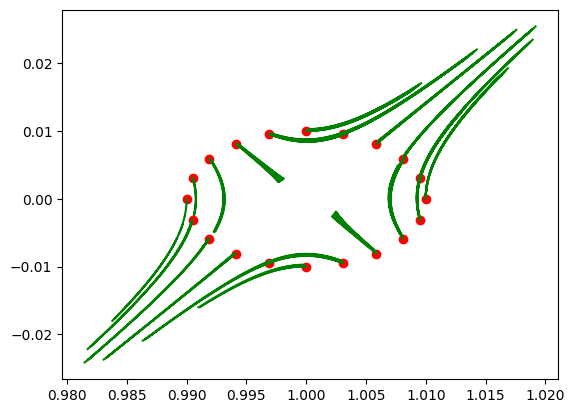

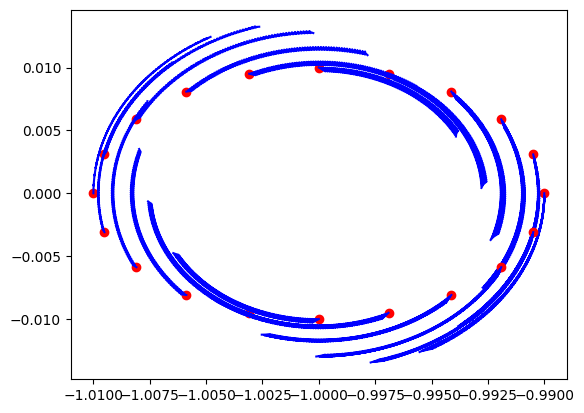

In [5]:
def adams_moulton_4(f1, f2, x0, y0, h, N):
    # Получаем первые 4 точки:
    x_values, y_values = runge_kutta_4(f1, f2, x0, y0, h, 4)
    
    for i in range(N - 4):
        # Предсказываем следующую точку с помощью Адамса-Башфорта
        x_pred = x_values[i] + h * (55 * f1(x_values[i], y_values[i]) - 59 * f1(x_values[i - 1], y_values[i - 1]) + 37 * f1(x_values[i - 2], y_values[i - 2]) - 9 * f1(x_values[i - 3], y_values[i - 3])) / 24
        y_pred = y_values[i] + h * (55 * f2(x_values[i], y_values[i]) - 59 * f2(x_values[i - 1], y_values[i - 1]) + 37 * f2(x_values[i - 2], y_values[i - 2]) - 9 * f2(x_values[i - 3], y_values[i - 3])) / 24


        # Корректор (Адамса-Моултона)
        x_next = x_values[i] + h * (9 * f1(x_pred, y_pred) + 19 * f1(x_values[i], y_values[i]) - 5 * f1(x_values[i - 1], y_values[i - 1]) + f1(x_values[i - 2], y_values[i - 2])) / 24
        y_next = y_values[i] + h * (9 * f2(x_pred, y_pred) + 19 * f2(x_values[i], y_values[i]) - 5 * f2(x_values[i - 1], y_values[i - 1]) + f2(x_values[i - 2], y_values[i - 2])) / 24


        x_values.append(x_next)
        y_values.append(y_next)
    
    return x_values, y_values


CustomDrow(adams_moulton_4, 0.01, 300)
    

### Неявный метод Рунге-Кутты 4 порядка (Гаусса-Лежандра)
Пробовал для решения промежуточной системы fsolve и root.

In [6]:
def implicit_runge_kutta_4(f, x0, y0, h, N):
    """
    Реализация неявного метода Рунге-Кутты 4-го порядка (Гаусса-Лежандра).

    Args:
        f: Функция, описывающая правые части системы дифференциальных уравнений.
           Должна принимать аргументы (x, y), где y - вектор значений.
        x0: Начальное значение x.
        y0: Начальное значение y (может быть вектором).
        h: Шаг интегрирования.
        N: Количество шагов.

    Returns:
        x_values: Список значений x.
        y_values: Список значений y.
    """
    x_values = [x0]
    y_values = [y0]

    # Коэффициенты метода Гаусса-Лежандра
    a = [[1/4, (1/4) - (np.sqrt(3)/6)], [(1/4) + (np.sqrt(3)/6), 1/4]]
    b = [1/2, 1/2]
    c = [(1/2) - (np.sqrt(3)/6), (1/2) + (np.sqrt(3)/6)]

    def equations(k, x, y):
        k1, k2 = k
        x1 = x + c[0] * h
        y1 = y + a[0][0] * h * k1 + a[0][1] * h * k2
        x2 = x + c[1] * h
        y2 = y + a[1][0] * h * k1 + a[1][1] * h * k2
        eq1 = k1 - f(x1, y1)
        eq2 = k2 - f(x2, y2)
        return [eq1, eq2]

    for i in range(N):
        k1, k2 = fsolve(equations, [0, 0], args=(x_values[-1], y_values[-1]))

        x_next = x_values[-1] + h * (b[0] * k1 + b[1] * k2)
        # Исправленное вычисление y_next
        y_next = y_values[-1] + h * (a[0][0] * k1 + a[0][1] * k2)

        x_values.append(x_next)
        y_values.append(y_next)

    return x_values, y_values

CustomDrow(implicit_runge_kutta_4, 0.01, 150)

TypeError: implicit_runge_kutta_4() takes 5 positional arguments but 6 were given

##### Попробуем метод Нютона, для решения промежуточной системы

In [ ]:
def newton_method(F, J, x0, tol=1e-6, max_iter=100):
    x = x0
    for _ in range(max_iter):
        # Вычисляем значения функций и матрицу Якоби
        Fx = F(x)
        Jx = J(x)

        # Решаем линейную систему Jx * delta = -Fx
        delta = np.linalg.solve(Jx, -Fx)

        # Обновляем приближение
        x = x + delta

        # Проверяем условие сходимости
        if np.linalg.norm(delta) < tol:
            return x

    raise ValueError("Метод Ньютона не сошелся за заданное число итераций.")


def derivative(f, x, y, arg_index):
    h = 1e-6

    if arg_index == 0:
        return (f(x + h, y) - f(x - h, y)) / (2 * h)
    elif arg_index == 1:
        return (f(x, y + h) - f(x, y - h)) / (2 * h)
    else:
        raise ValueError("Неверный индекс аргумента.")

In [8]:
def f(x, y):
    return [y[0], x ** 2 - 1]


def implicit_runge_kutta_4(f1, f2, x0, y0, h, N):
    x_values = [x0]
    y_values = [y0]

    for i in range(N):
        # Коэффициенты метода Гаусса-Лежандра
        a = [[1/4, (1/4) - (np.sqrt(3)/6)], [(1/4) + (np.sqrt(3)/6), 1/4]]
        b = [1/2, 1/2]
        c = [(1/2) - (np.sqrt(3)/6), (1/2) + (np.sqrt(3)/6)]

        # Решение системы уравнений для k1, k2
        def F(k):
            k1, k2 = k
            x1 = x_values[-1] + c[0] * h
            y1 = y_values[-1] + a[0][0] * h * k1 + a[0][1] * h * k2 
            x2 = x_values[-1] + c[1] * h
            y2 = y_values[-1] + a[1][0] * h * k1 + a[1][1] * h * k2
            eq1 = k1 - f1(x1, y1)
            eq2 = k2 - f2(x2, y2)
            return np.array([eq1, eq2])
        
        def J(k):
            k1, k2 = k
            x1 = x_values[-1] + c[0] * h
            y1 = y_values[-1] + a[0][0] * h * k1 + a[0][1] * h * k2 
            x2 = x_values[-1] + c[1] * h
            y2 = y_values[-1] + a[1][0] * h * k1 + a[1][1] * h * k2
            return np.array([[1 - h * derivative(f1, x1, y1, 0), -h * derivative(f1, x1, y1, 1)],
                             [-h * derivative(f2, x2, y2, 0), 1 - h * derivative(f2, x2, y2, 1)]])

        k1, k2 = newton_method(F, J, [0, 0])

        # Вычисление следующей точки
        x_next = x_values[-1] + h * (b[0] * k1 + b[1] * k2)
        y_next = y_values[-1] + h * (b[0] * k1 + b[1] * k2)

        x_values.append(x_next)
        y_values.append(y_next)

    return x_values, y_values

# CustomDrow(implicit_runge_kutta_4, 0.01, 150)
R = 0.01
h = 0.01
N = 150
for phi in np.arange(0, 2 * np.pi, np.pi * 0.1):
    x_values, y_values = implicit_runge_kutta_4(f,  1 + R * np.cos(phi), R * np.sin(phi), h, N)
    plt.plot(x_values[0], y_values[0], marker='o', color='red')
    plt.plot(x_values, y_values, color='green')
plt.show()

for phi in np.arange(0, 2 * np.pi, np.pi * 0.1):
    x_values, y_values = implicit_runge_kutta_4(f, -1 + R * np.cos(phi), R * np.sin(phi), h, N)
    plt.plot(x_values[0], y_values[0], marker='o', color='red')
    plt.plot(x_values, y_values, color='blue')
plt.show()

TypeError: implicit_runge_kutta_4() missing 1 required positional argument: 'N'